### 1. İMPORTS

In [1]:
# kütüphaneler
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression

from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import HuberRegressor, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
pd.set_option("display.max_columns", None)

### 2. FEATURE ENGINEERING

In [2]:
import numpy as np

def enrich_features(data):
    df = data.copy()

    # Gereksiz kolonları temizle
    leak_cols = ["avg_calendar_price", "min_calendar_price", "max_calendar_price"]  # takvim fiyatları
    host_cols = [  # host ile ilgili fazla kolonlar
        "host_name_target_encoded",
        "host_location_target_encoded",
        "host_neighbourhood_target_encoded",
        "host_has_profile_pic_True",
    ]
    host_rt_cols = [c for c in df.columns if "host_response_time_" in c]  # host cevap süreleri
    id_time_cols = [  # ID ve zaman kolonları
        "id", "listing_id", "host_id", "scrape_id",
        "last_scraped", "calendar_last_scraped", "first_review", "last_review"
    ]
    raw_text_cols = [c for c in df.columns if ("description" in c or "name" in c)]  # ham text
    high_card_cols = [  # çok farklı değerli kategorik kolonlar
        "host_name", "host_location", "host_neighbourhood",
        "neighbourhood", "neighbourhood_cleansed"
    ]
    review_score_cols = [c for c in df.columns if c.startswith("review_scores_")]  # review skorları

    drop_cols = leak_cols + host_cols + host_rt_cols + id_time_cols + high_card_cols + review_score_cols
    drop_cols = [c for c in drop_cols if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)  # varsa sil

    # Eksik değerleri hesapla
    df["null_total"] = df.isnull().sum(axis=1)  # satırda kaç boş var
    df["null_fraction"] = df.isnull().mean(axis=1)  # boş oranı

    # Text özellikleri
    text_cols = [c for c in df.columns if "description" in c or "name" in c]
    for col in text_cols:
        df[col] = df[col].astype(str)
        df[col + "_chars"] = df[col].str.len()  # karakter sayısı
        df[col + "_words"] = df[col].apply(lambda t: len(t.split()))  # kelime sayısı

    # Basit etkileşim özellikleri
    if "accommodates" in df.columns and "bedrooms" in df.columns:
        df["accom_bed_ratio"] = df["accommodates"] / (df["bedrooms"] + 1)  # kişi/oda oranı

    if "price" in df.columns and "cleaning_fee" in df.columns:
        df["price_to_clean"] = df["price"] / (df["cleaning_fee"] + 1)  # fiyat/temizlik oranı

    # Availability özellikleri
    avail_cols = [c for c in df.columns if "availability" in c]
    if len(avail_cols) > 0:
        df["avail_min"] = df[avail_cols].min(axis=1)  # en az müsaitlik
        df["avail_max"] = df[avail_cols].max(axis=1)  # en çok müsaitlik

    # Review tabanlı özellik
    if "reviews_per_month" in df.columns:
        df["reviews_scaled"] = np.log1p(df["reviews_per_month"])  # log ile ölçekle

    # Boolean kolonları int yap
    bool_cols = df.select_dtypes(include=["bool"]).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

    return df


### 3. DATA LOAD + FE

In [4]:
# Veri seti yolları tanımlama
train_path = "./processed_data/train_unscaled.csv"
val_path   = "./processed_data/val_unscaled.csv"
test_path  = "./processed_data/test_unscaled.csv"

# CSV dosyaları
train = pd.read_csv(train_path)
val   = pd.read_csv(val_path)
test  = pd.read_csv(test_path)

# Feature engineering fonksiyonu tüm veri setlerine uygulama
train = enrich_features(train)
val   = enrich_features(val)
test  = enrich_features(test)

target = "price"

# Eğitim özellikleri 
X_train = train.drop(columns=[target])
y_train = train[target]

# Doğrulama seti
X_val = val.drop(columns=[target])
y_val = val[target]

# Test seti
X_test = test.drop(columns=[target])
y_test = test[target]

# FE sonrası veri boyutları ekrana yazdırma
print("After FE:", X_train.shape, X_val.shape, X_test.shape)

After FE: (12016, 99) (4006, 99) (4006, 99)


### 4. DATA VISUALIZATION

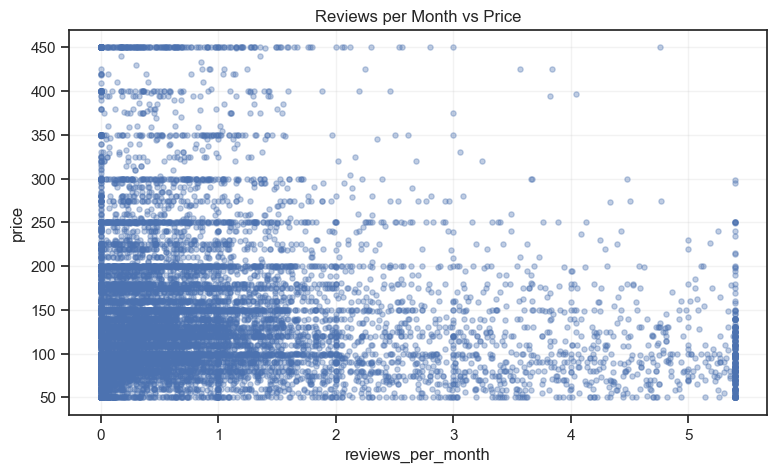

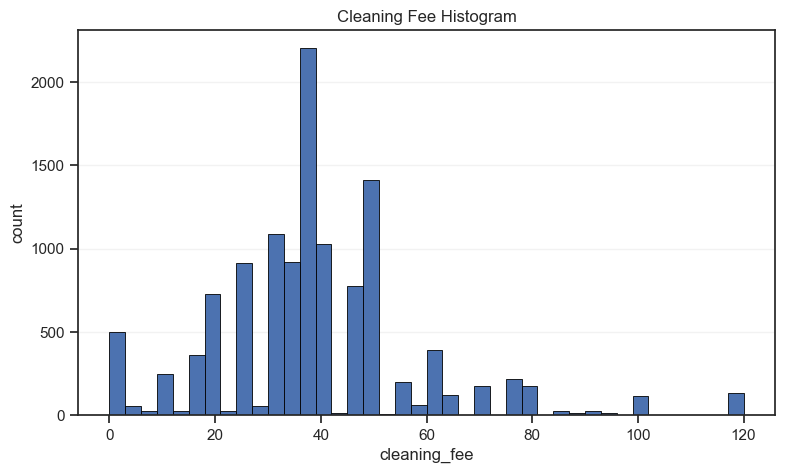

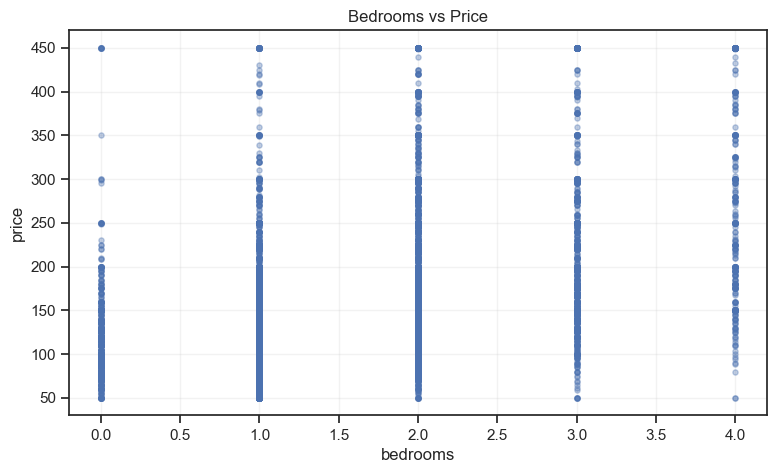

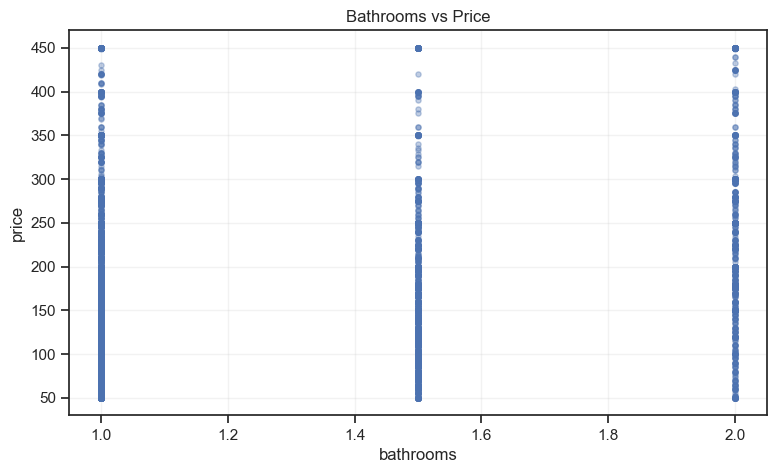

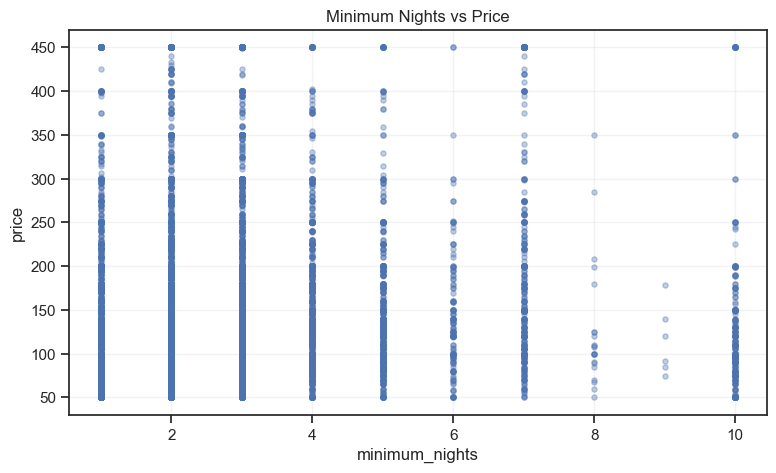

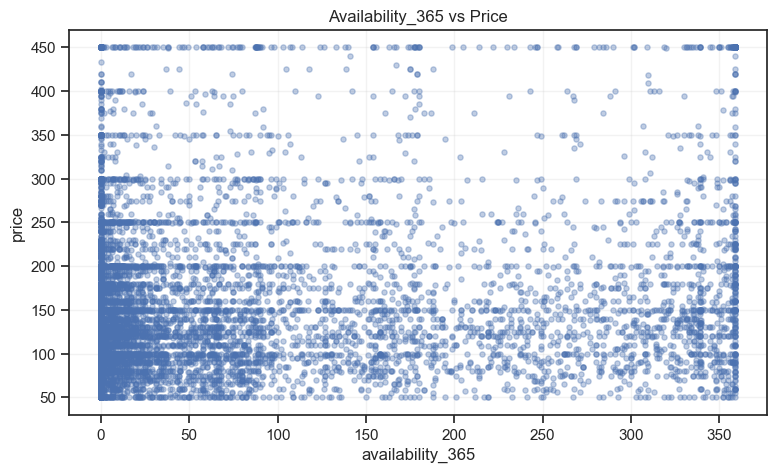

In [5]:
# Veri Görselleştirme
def _col_exists(df, col):
    return col in df.columns  # kolon var mı kontrol et

def _to_numeric_safe(s):
    return pd.to_numeric(s, errors="coerce")  # sayıya çevir, hata varsa NaN yap

def _sample_df(df, cols, sample=12000, rs=42, clip=True):
    tmp = df[cols].copy()

    # kolonları sayısala çevir
    for c in cols:
        tmp[c] = _to_numeric_safe(tmp[c])

    tmp = tmp.dropna()  # boşları at

    # price varsa sıfır ve negatifleri çıkar
    if "price" in cols:
        tmp = tmp[tmp["price"] > 0]

    # uç değerleri kırp (sürekli değişkenler)
    if clip:
        for c in cols:
            if tmp[c].nunique() > 10:
                lo = tmp[c].quantile(0.02)
                hi = tmp[c].quantile(0.98)
                tmp[c] = tmp[c].clip(lo, hi)

    # örnek al
    if sample and len(tmp) > sample:
        tmp = tmp.sample(sample, random_state=rs)

    return tmp

def _clip_quantile_series(s, lo=0.01, hi=0.99):
    s = pd.to_numeric(s, errors="coerce")
    s = s.dropna()
    if len(s) == 0:
        return s
    ql = s.quantile(lo)
    qh = s.quantile(hi)
    return s.clip(ql, qh)  # uç değerleri kırp

# 1) Reviews per month - Scatter
def plot_scatter_reviews_per_month(df, x_col="reviews_per_month", y_col="price", sample=12000):
    if not (_col_exists(df, x_col) and _col_exists(df, y_col)):
        print(f"❌ Kolon yok: {x_col} veya {y_col}")
        return

    tmp = _sample_df(df, [x_col, y_col], sample=sample)

    plt.figure(figsize=(9, 5))
    plt.scatter(tmp[x_col], tmp[y_col], alpha=0.35, s=14)
    plt.title("Reviews per Month vs Price")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.25)
    plt.show()

# 2) Cleaning fee - Histogram
def plot_hist_cleaning_fee(df, col="cleaning_fee", bins=40):
    if not _col_exists(df, col):
        print(f"❌ Kolon yok: {col}")
        return

    tmp = _to_numeric_safe(df[col]).dropna()

    plt.figure(figsize=(9, 5))
    plt.hist(tmp, bins=bins, edgecolor="black", linewidth=0.6)
    plt.title("Cleaning Fee Histogram")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.grid(True, axis="y", alpha=0.25)
    plt.show()

# 3) Bedrooms vs Price - Scatter
def plot_scatter_bedrooms(df, x_col="bedrooms", y_col="price", sample=12000):
    if not (_col_exists(df, x_col) and _col_exists(df, y_col)):
        print(f"❌ Kolon yok: {x_col} veya {y_col}")
        return

    tmp = _sample_df(df, [x_col, y_col], sample=sample)

    plt.figure(figsize=(9, 5))
    plt.scatter(tmp[x_col], tmp[y_col], alpha=0.35, s=14)
    plt.title("Bedrooms vs Price")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.25)
    plt.show()

# 4) Bathrooms vs Price - Scatter
def plot_scatter_bathrooms(df, x_col="bathrooms", y_col="price", sample=12000):
    if not (_col_exists(df, x_col) and _col_exists(df, y_col)):
        print(f"❌ Kolon yok: {x_col} veya {y_col}")
        return

    tmp = _sample_df(df, [x_col, y_col], sample=sample)

    plt.figure(figsize=(9, 5))
    plt.scatter(tmp[x_col], tmp[y_col], alpha=0.35, s=14)
    plt.title("Bathrooms vs Price")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.25)
    plt.show()

# 5) Minimum nights vs Price - Scatter (uç değer kırp)
def plot_scatter_min_nights(df, x_col="minimum_nights", y_col="price", sample=12000):
    if not (_col_exists(df, x_col) and _col_exists(df, y_col)):
        print(f"❌ Kolon yok: {x_col} veya {y_col}")
        return

    tmp = _sample_df(df, [x_col, y_col], sample=sample)
    tmp[x_col] = _clip_quantile_series(tmp[x_col], 0.01, 0.99)  # uç değerleri kırp

    plt.figure(figsize=(9, 5))
    plt.scatter(tmp[x_col], tmp[y_col], alpha=0.35, s=14)
    plt.title("Minimum Nights vs Price")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.25)
    plt.show()

# 6) Availability_365 vs Price - Scatter
def plot_scatter_availability_365(df, x_col="availability_365", y_col="price", sample=12000):
    if not (_col_exists(df, x_col) and _col_exists(df, y_col)):
        print(f"❌ Kolon yok: {x_col} veya {y_col}")
        return

    tmp = _sample_df(df, [x_col, y_col], sample=sample)

    plt.figure(figsize=(9, 5))
    plt.scatter(tmp[x_col], tmp[y_col], alpha=0.35, s=14)
    plt.title("Availability_365 vs Price")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.25)
    plt.show()

# Grafikleri çiz
plot_scatter_reviews_per_month(train)
plot_hist_cleaning_fee(train)
plot_scatter_bedrooms(train)
plot_scatter_bathrooms(train)
plot_scatter_min_nights(train)
plot_scatter_availability_365(train)


### 5. SCALING

In [6]:
# Tüm veri setlerini aynı şekilde ölçekle
scaler = StandardScaler()

Xtr_scaled = scaler.fit_transform(X_train)  # train'i ölçekle ve öğren
Xv_scaled  = scaler.transform(X_val)        # val setini aynı ölçekle
Xt_scaled  = scaler.transform(X_test)       # test setini aynı ölçekle


### 6. FEATURE SELECTION

In [7]:
# En önemli 50 özelliği seçmek için özellik seçimi uygulama
selector = SelectKBest(mutual_info_regression, k=50)

Xtr_fs = selector.fit_transform(Xtr_scaled, y_train)
Xv_fs  = selector.transform(Xv_scaled)
Xt_fs  = selector.transform(Xt_scaled)

print("FS shape:", Xtr_fs.shape)

FS shape: (12016, 50)


### 7. DR (PCA)

PCA comp: 31


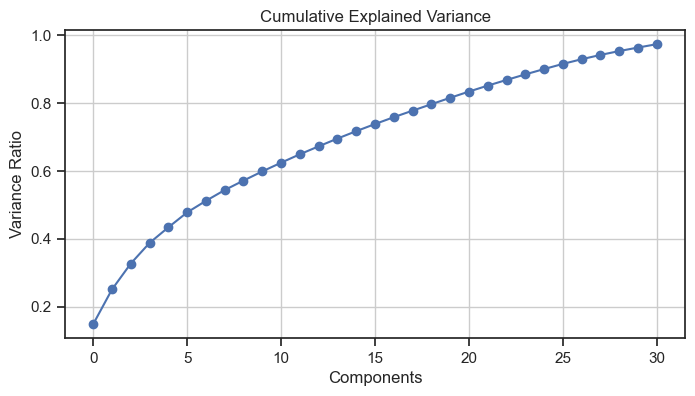

In [8]:
# PCA ile boyut azaltma
pca = PCA(n_components=0.97)

Xtr_pca = pca.fit_transform(Xtr_fs)
Xv_pca  = pca.transform(Xv_fs)
Xt_pca  = pca.transform(Xt_fs)

print("PCA comp:", Xtr_pca.shape[1])

# Açıklanan varyansın kümülatif grafiği çizilir
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')   # bileşenlerin kümülatif varyansı
plt.title("Cumulative Explained Variance")
plt.xlabel("Components")   # x ekseni etiketi
plt.ylabel("Variance Ratio")   # y ekseni etiketi
plt.grid()  # ızgara göster
plt.show()

### 8. ASSESSMENT FUNCTIONS

In [9]:
# Verilen modelin performans metriklerini hesaplama
def assess(model, X, y, label):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae  = mean_absolute_error(y, preds)
    r2   = r2_score(y, preds)

    print(f"\n### {label} ###")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.4f}")

    return rmse, mae, r2

# Metrikleri hesaplar fakat ekrana yazmaz (sessiz mod)
def assess_silent(model, X, y):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae  = mean_absolute_error(y, preds)
    r2   = r2_score(y, preds)
    return rmse, mae, r2

# Aynı modeli hem train hem val veri setinde art arda değerlendirir
def assess_pair(model, Xtr, ytr, Xv, yv, label):
    print(f"\n--- {label} RESULTS ---")
    assess(model, Xtr, ytr, f"{label} TRAIN")
    assess(model, Xv,  yv,  f"{label} VAL")

### 9. MODEL 1: MLP

In [10]:
# MLP regresyon modeli tanımlanır
MLP_PARAMS = {
    "hidden_layer_sizes": (100, 50),
    "activation": "tanh",
    "solver": "adam",
    "alpha": 0.001,
    "learning_rate": "adaptive",
    "max_iter": 600,
    "early_stopping": True,
    "random_state": 12
}

mlp = MLPRegressor(
    hidden_layer_sizes=MLP_PARAMS["hidden_layer_sizes"],
    activation=MLP_PARAMS["activation"],
    solver=MLP_PARAMS["solver"],
    alpha=MLP_PARAMS["alpha"],
    learning_rate=MLP_PARAMS["learning_rate"],
    max_iter=MLP_PARAMS["max_iter"],
    early_stopping=MLP_PARAMS["early_stopping"],
    random_state=MLP_PARAMS["random_state"]
)

# Model PCA ile indirgenmiş eğitim verisi üzerinde eğitme
mlp.fit(Xtr_pca, y_train)

# Modelin train ve validation performansı birlikte değerlendirme
assess_pair(mlp, Xtr_pca, y_train, Xv_pca, y_val, "MLP")
# Model test seti üzerinde ayrıca değerlendirme
assess(mlp, Xt_pca, y_test, "MLP TEST")


--- MLP RESULTS ---

### MLP TRAIN ###
RMSE: 110.587
MAE : 14.193
R²  : 0.4977

### MLP VAL ###
RMSE: 121.809
MAE : 25.358
R²  : 0.3707

### MLP TEST ###
RMSE: 46.914
MAE : 24.363
R²  : 0.7731


(46.91384792797974, 24.363209935045948, 0.7731173140825367)

### 10. MODEL 2: HUBER

In [11]:
# Huber Regressor modeli
HUBER_PARAMS = {
    "epsilon": 1.2,
    "alpha": 0.0005,
    "max_iter": 250
}

huber = HuberRegressor(
    epsilon=HUBER_PARAMS["epsilon"],
    alpha=HUBER_PARAMS["alpha"],
    max_iter=HUBER_PARAMS["max_iter"]
)

# Model PCA ile indirgenmiş eğitim verisi üzerinde eğitme
huber.fit(Xtr_pca, y_train)

# Eğitim ve doğrulama seti performansı değerlendirme
assess_pair(huber, Xtr_pca, y_train, Xv_pca, y_val, "HUBER")
# Test seti performansı ayrı olarak değerlendirme
assess(huber, Xt_pca, y_test, "HUBER TEST")


--- HUBER RESULTS ---

### HUBER TRAIN ###
RMSE: 123.250
MAE : 42.746
R²  : 0.3760

### HUBER VAL ###
RMSE: 136.295
MAE : 40.072
R²  : 0.2121

### HUBER TEST ###
RMSE: 75.349
MAE : 40.100
R²  : 0.4147


(75.34909641411919, 40.099884568807646, 0.41473124361912783)

### 11. MODEL 3: ELASTIC NET

In [12]:
# L1 ve L2 cezalarını birleştiren ElasticNet regresyon modeli 
ELASTIC_PARAMS = {
    "alpha": 0.001,
    "l1_ratio": 0.5,
    "max_iter": 3000,
    "random_state": 42
}

elastic = ElasticNet(
    alpha=ELASTIC_PARAMS["alpha"],
    l1_ratio=ELASTIC_PARAMS["l1_ratio"],
    max_iter=ELASTIC_PARAMS["max_iter"],
    random_state=ELASTIC_PARAMS["random_state"]
)

# Model PCA ile indirgenmiş eğitim verisi üzerinde eğitme
elastic.fit(Xtr_pca, y_train)

# Eğitim ve doğrulama seti performansı değerlendirme
assess_pair(elastic, Xtr_pca, y_train, Xv_pca, y_val, "ELASTIC")
# Test seti performansı ayrı olarak değerlendirme
assess(elastic, Xt_pca, y_test, "ELASTIC TEST")


--- ELASTIC RESULTS ---

### ELASTIC TRAIN ###
RMSE: 113.225
MAE : 46.489
R²  : 0.4734

### ELASTIC VAL ###
RMSE: 133.686
MAE : 45.212
R²  : 0.2420

### ELASTIC TEST ###
RMSE: 74.526
MAE : 44.324
R²  : 0.4274


(74.52590810609003, 44.323680512284334, 0.4274495020651754)

### 12. MODEL 4: HistGradientBoosting

In [13]:
# Histogram tabanlı gradient boosting regresyon modeli
HGB_PARAMS = {
    "learning_rate": 0.06,
    "max_depth": 8,
    "max_iter": 800,
    "min_samples_leaf": 25,
    "l2_regularization": 0.0,
    "random_state": 42
}

hgb = HistGradientBoostingRegressor(
    learning_rate=HGB_PARAMS["learning_rate"],
    max_depth=HGB_PARAMS["max_depth"],
    max_iter=HGB_PARAMS["max_iter"],
    min_samples_leaf=HGB_PARAMS["min_samples_leaf"],
    l2_regularization=HGB_PARAMS["l2_regularization"],
    random_state=HGB_PARAMS["random_state"]
)

# Model FS sonrası eğitim verisi üzerinde eğitme
hgb.fit(Xtr_fs, y_train)

# Eğitim ve doğrulama seti performansı değerlendirme
assess_pair(hgb, Xtr_fs, y_train, Xv_fs, y_val, "HISTGB")
# Test seti performansı ayrı olarak değerlendirme
assess(hgb, Xt_fs, y_test, "HISTGB TEST")


--- HISTGB RESULTS ---

### HISTGB TRAIN ###
RMSE: 97.343
MAE : 11.683
R²  : 0.6108

### HISTGB VAL ###
RMSE: 118.688
MAE : 12.374
R²  : 0.4025

### HISTGB TEST ###
RMSE: 28.839
MAE : 9.970
R²  : 0.9143


(28.839002262803845, 9.970409024192268, 0.9142646933383174)

### 13. MODEL 5: LİGHTGBM

In [14]:
# LightGBM Regressor modeli
LGBM_PARAMS = {
    "n_estimators": 1200,
    "learning_rate": 0.03,
    "num_leaves": 63,
    "max_depth": -1,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0,
    "random_state": 42,
    "n_jobs": -1
}

lgbm = LGBMRegressor(
    n_estimators=LGBM_PARAMS["n_estimators"],
    learning_rate=LGBM_PARAMS["learning_rate"],
    num_leaves=LGBM_PARAMS["num_leaves"],
    max_depth=LGBM_PARAMS["max_depth"],
    subsample=LGBM_PARAMS["subsample"],
    colsample_bytree=LGBM_PARAMS["colsample_bytree"],
    reg_alpha=LGBM_PARAMS["reg_alpha"],
    reg_lambda=LGBM_PARAMS["reg_lambda"],
    random_state=LGBM_PARAMS["random_state"],
    n_jobs=LGBM_PARAMS["n_jobs"]
)

# Model FS sonrası eğitim verisi üzerinde eğitme
lgbm.fit(Xtr_fs, y_train)

# Eğitim ve doğrulama seti performansı değerlendirme
assess_pair(lgbm, Xtr_fs, y_train, Xv_fs, y_val, "LIGHTGBM")
# Test seti performansı ayrı olarak değerlendirme
assess(lgbm, Xt_fs, y_test, "LIGHTGBM TEST")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6501
[LightGBM] [Info] Number of data points in the train set: 12016, number of used features: 50
[LightGBM] [Info] Start training from score 153.443326

--- LIGHTGBM RESULTS ---

### LIGHTGBM TRAIN ###
RMSE: 42.707
MAE : 3.454
R²  : 0.9251

### LIGHTGBM VAL ###
RMSE: 116.024
MAE : 10.526
R²  : 0.4291

### LIGHTGBM TEST ###
RMSE: 36.868
MAE : 8.963
R²  : 0.8599


(36.86847781703538, 8.962976562304142, 0.8598769254202003)

### 14. SUMMARY

In [15]:
summary_val = pd.DataFrame({
    "Model": ["MLP", "Huber", "ElasticNet", "HistGradientBoosting", "LightGBM"],

    "Val_MAE": [  # validation setinde MAE hesapla
        assess_silent(mlp,     Xv_pca, y_val)[0],
        assess_silent(huber,   Xv_pca, y_val)[0],
        assess_silent(elastic, Xv_pca, y_val)[0],
        assess_silent(hgb,     Xv_fs,  y_val)[0],
        assess_silent(lgbm,    Xv_fs,  y_val)[0],
    ],

    "Val_RMSE": [  # validation setinde RMSE hesapla
        assess_silent(mlp,     Xv_pca, y_val)[1],
        assess_silent(huber,   Xv_pca, y_val)[1],
        assess_silent(elastic, Xv_pca, y_val)[1],
        assess_silent(hgb,     Xv_fs,  y_val)[1],
        assess_silent(lgbm,    Xv_fs,  y_val)[1],
    ],

    "Val_R2": [  # validation setinde R² hesapla
        assess_silent(mlp,     Xv_pca, y_val)[2],
        assess_silent(huber,   Xv_pca, y_val)[2],
        assess_silent(elastic, Xv_pca, y_val)[2],
        assess_silent(hgb,     Xv_fs,  y_val)[2],
        assess_silent(lgbm,    Xv_fs,  y_val)[2],
    ]
})

# R²'ye göre en iyi modelleri sırala
summary_val = summary_val.sort_values("Val_R2", ascending=False).reset_index(drop=True)
summary_val  # tabloyu göster


,Model,Val_MAE,Val_RMSE,Val_R2
0,LightGBM,116.023692,10.526424,0.429076
1,HistGradientBoosting,118.688428,12.373906,0.402550
2,MLP,121.809076,25.357883,0.370719
3,ElasticNet,133.685882,45.212488,0.242023
4,Huber,136.295320,40.072295,0.212144
